In [1]:
# Standard imports
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
try:
    import xspec 
except: # If ModuleNotFoundError, initialize HEASOFT.
    print(f"PyXspec was not found, please initialize HEASOFT first in shell")
import xsnap
from xsnap import spectrum, temperature

## Spectrum fitting for SN2014C from Chandra data.
## ObsId: 17549 and 21077

In [2]:
spec_files = ['./17569/primary/spec17569_grp.pi', 
              './21077/primary/spec21077_grp.pi']

# Using parameters from this paper:
# https://iopscience.iop.org/article/10.3847/1538-4357/ad9c76

# Time of explosion in MJD
tExplosion= 56658.91 # MJD

# Distance in Mpc
dist = 15.1 # Mpc

In [3]:
# Use constrain temperature with T = 34 keV (t/13)^(-0.25)
# Meaning it's 34 * (1/13)^(-0.25) t^(-0.25)
norm = 34 * (1/13)**(-0.25)
exp = -0.25

temp = temperature.TemperatureEstimator(norm=norm, exponent=exp, tExplosion=tExplosion)
df_temp = temp.estimate(files=spec_files)
df_temp # here we estimate the temperature based on our model

,time_since_explosion,lo_time_err,hi_time_err,temperature,lo_temp_err,hi_temp_err
0,393.706775,0.0,0.0,14.493442,0.0,0.0
1,1565.644759,0.0,0.0,10.263405,0.0,0.0


 Solar Abundance Vector set to aspl:  Asplund M., Grevesse N., Sauval A.J. & Scott P., ARAA, 47, 481 (2009)

1 spectrum  in use
 
Spectral Data File: /Users/ferdinand/Research/WynnXraySN/Tutorials/notebook/17569/primary/spec17569_grp.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.536e-02 +/- 1.601e-03 (99.8 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-192
  Telescope: CHANDRA Instrument: ACIS  Channel Type: PI
  Exposure Time: 9914 sec
 Using fit statistic: chi
 Using Background File                spec17569_bkg.pi
  Background Exposure Time: 9914 sec
 Using Response (RMF) File            spec17569.rmf for Source 1
 Using Auxiliary Response (ARF) File  spec17569.corr.arf


ignore:     1 channels ignored from  source number 1
     2 channels (1-2) ignored in spectrum #     1
     5 channels (188-192) ignored in spectrum #     1


Model TBabs<1>*zTBabs<2>*bremss<3> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp

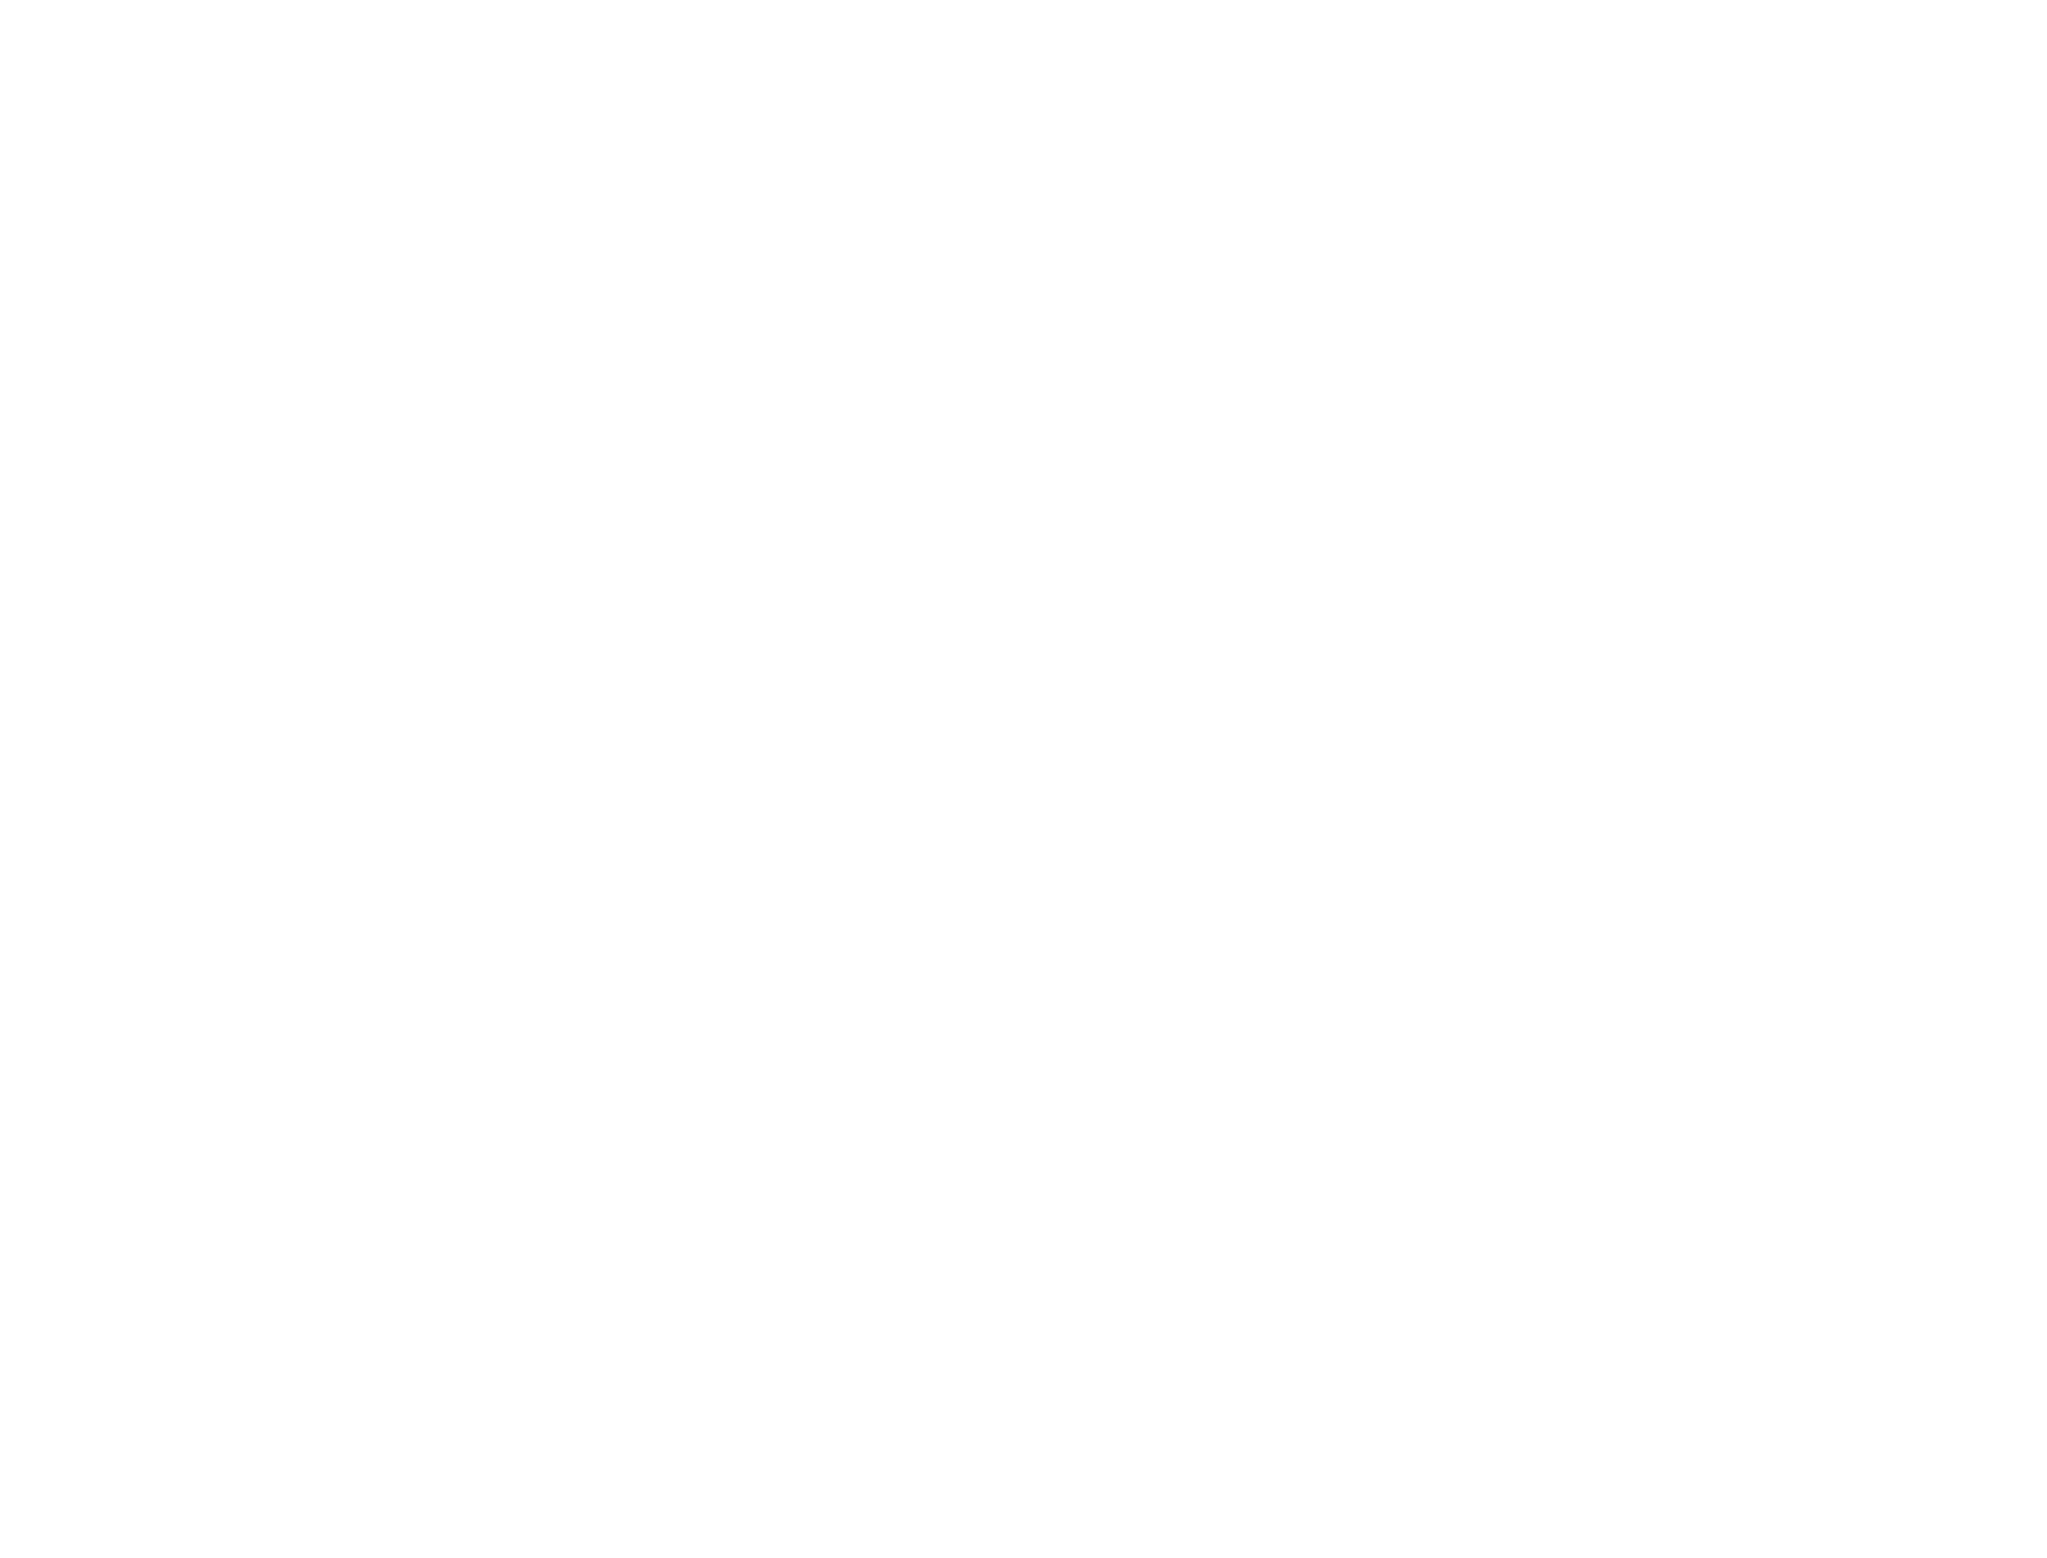

 Parameter   Confidence Range (1)
     2      2.30414      2.92709    (-0.29848,0.32447)
     5  0.000158819   0.00018985    (-1.48813e-05,1.61498e-05)
Spectrum 1: Lower range bound          0.3 reset by matrix bound to          0.3
Parameter distribution is derived from fit covariance matrix.
 Model Flux 8.638e-05 photons (5.9419e-13 ergs/cm^2/s) range (0.30000 - 10.000 keV)
     Error range 8.055e-05 - 9.211e-05    (5.504e-13 - 6.355e-13)  (68.00% confidence)

Fit statistic  : C-Statistic                  215.96     using 185 bins.

Test statistic : Chi-Squared                  244.75     using 185 bins.
 Null hypothesis probability of 1.56e-03 with 183 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                  609.99     using 185 bins.

Test statistic : Chi-Squared                 3405.62     using 185 bins.
 Null hypothesis probability of 0.00e+00 with 183 degrees of freedom
 Current data and model not fit yet.
         valid fit or chai

In [4]:
# Initialize SpectrumManager class to help in plotting light curve
manager = spectrum.SpectrumManager(tExplosion = tExplosion)

# Fit the first spectrum
# SpectrumFit by default use 'aspl' for Solar Abundance
spec17569 = spectrum.SpectrumFit() 
spec17569.load_data(spec_files[0])
spec17569.set_rebin(5, 3)
spec17569.ignore("**-0.5 8.0-**") # Chandra is well-calibrated in 0.5 - 8.0 keV

# Now, we set the model that we want
# Supposedly we use TBabs, TBabs can be automatically 
# calculated through the RA and Dec Obj available in 
# the header of the spectrum file
spec17569.set_model(
    "tbabs*ztbabs*bremss",
    zTBabs_nH=2.7,
    zTBabs_Redshift=0,
    # Here, we freeze the temperature for tutorial purposes
    bremss_kT=f"{df_temp['temperature'].iloc[0]} -1",
    bremss_norm=0
)

spec17569.fit()
# We set plot, if device="/null" it automatically uses matplotlib to plot
spec17569.set_plot("ldata", device="/svg")
# Fitting the parameters for zTBabs nH and bremss norm
spec17569.get_params("1.0 2 5")
# Get both absorbed and unabsorbed fluxes
df_flux = spec17569.get_fluxes()
# Getting observation time to help in plotting the light curve
spec17569.get_time()
# Getting count rates
spec17569.get_counts()
# Getting luminosity based on given flux and distance
spec17569.get_lumin(fluxes=df_flux['unabsorbed'], distance=dist) 

# Load the spectrum to the manager
# Due to the nature of PyXspec,
# You must fit the spectrum and 
# load it to the manager one by one
manager.load(spec17569)

 Solar Abundance Vector set to aspl:  Asplund M., Grevesse N., Sauval A.J. & Scott P., ARAA, 47, 481 (2009)

Fit statistic  : C-Statistic                  609.99     using 185 bins.

Test statistic : Chi-Squared                 3405.62     using 185 bins.
 Null hypothesis probability of 0.00e+00 with 183 degrees of freedom
 Current data and model not fit yet.

1 spectrum  in use
 
Spectral Data File: /Users/ferdinand/Research/WynnXraySN/Tutorials/notebook/21077/primary/spec21077_grp.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.856e-02 +/- 1.568e-03 (99.8 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-345
  Telescope: CHANDRA Instrument: ACIS  Channel Type: PI
  Exposure Time: 1.979e+04 sec
 Using fit statistic: cstat
 Using Background File                spec21077_bkg.pi
  Background Exposure Time: 1.979e+04 sec
 Using Response (RMF) File            spec21077.rmf for Source 1
 Using Auxiliary Response (ARF) File  spec21077.corr.arf


Fit statistic

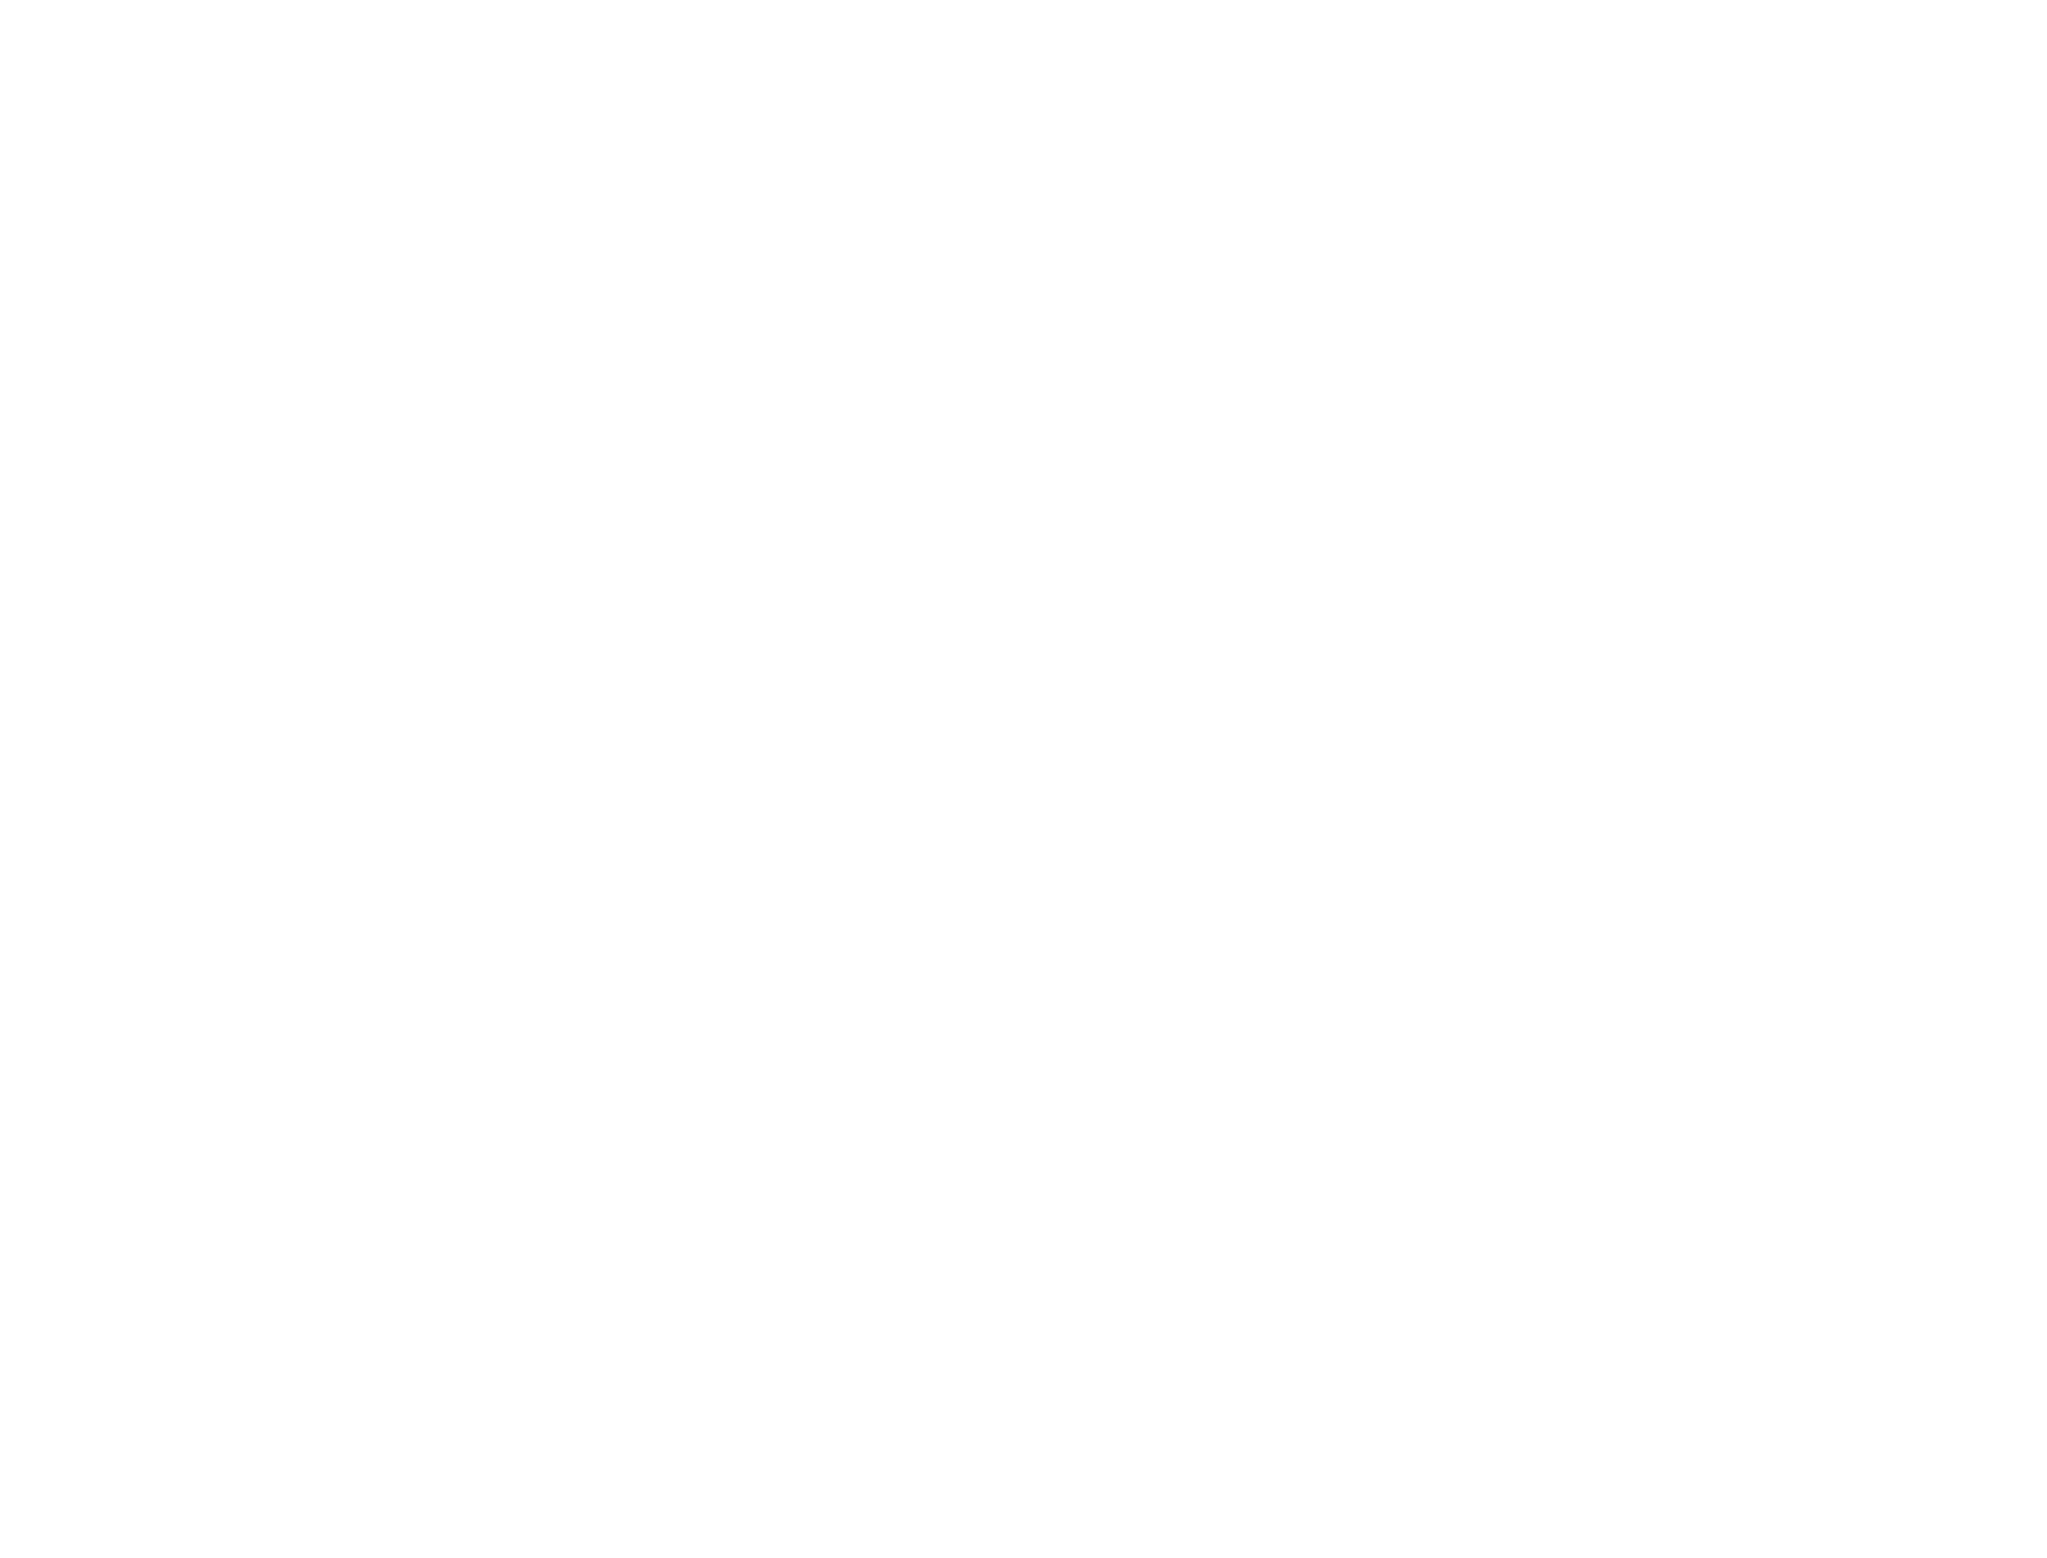

              374.16     using 331 bins.

Test statistic : Chi-Squared                  504.96     using 331 bins.
 Null hypothesis probability of 1.41e-09 with 329 degrees of freedom
 Parameter   Confidence Range (1)
     2     0.420216     0.551138    (-0.0644189,0.0665032)
     5  0.000181486  0.000198013    (-8.11503e-06,8.4117e-06)
Spectrum 1: Lower range bound          0.3 reset by matrix bound to          0.3
Parameter distribution is derived from fit covariance matrix.
 Model Flux 0.00016218 photons (7.9563e-13 ergs/cm^2/s) range (0.30000 - 10.000 keV)
     Error range 0.0001567 - 0.0001678    (7.663e-13 - 8.215e-13)  (68.00% confidence)

Fit statistic  : C-Statistic                  376.27     using 331 bins.

Test statistic : Chi-Squared                  537.16     using 331 bins.
 Null hypothesis probability of 3.18e-12 with 329 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                  567.72     using 331 bins.

Test statistic : 

In [5]:
# Fit the second spectrum by re-doing what we did in the first spectrum
spec21077 = spectrum.SpectrumFit() 

# Use clear=True in loading new data to clear the previous spectrum loaded in PyXspec
# One can also just use xspec.AllData.clear() before fitting the second spectrum
spec21077.load_data(spec_files[1], clear=True)
spec21077.set_rebin(5, 3)
spec21077.ignore("**-0.5 8.0-**") # Chandra is well-calibrated in 0.5 - 8.0 keV

spec21077.set_model(
    "tbabs*ztbabs*bremss",
    zTBabs_nH=2.7,
    zTBabs_Redshift=0,
    # Here, we freeze the temperature for tutorial purposes
    bremss_kT=f"{df_temp['temperature'].iloc[1]} -1",
    bremss_norm=0
)

spec21077.fit()
spec21077.set_plot("ldata", device="/svg")
spec21077.get_params("1.0 2 5")
df_flux = spec21077.get_fluxes()
spec21077.get_time()
spec21077.get_counts()
spec21077.get_lumin(fluxes=df_flux['unabsorbed'], distance=dist) 
manager.load(spec21077)

## Plotting light curves
The light curves will be a normal matplotlib plot with labels is grouped by instruments

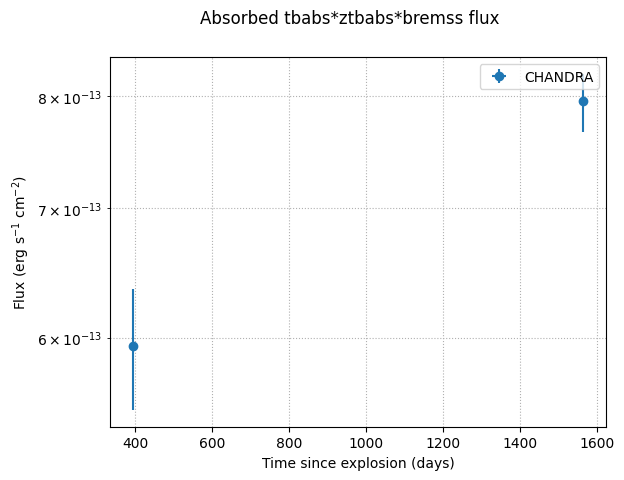

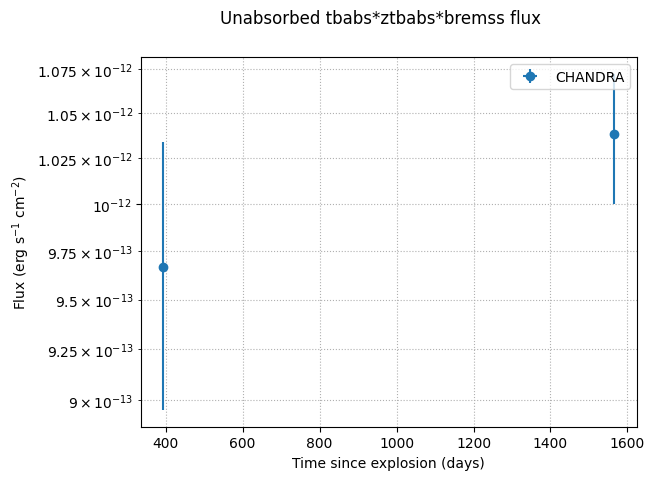

In [7]:
fig_fluxes = manager.plot_flux()

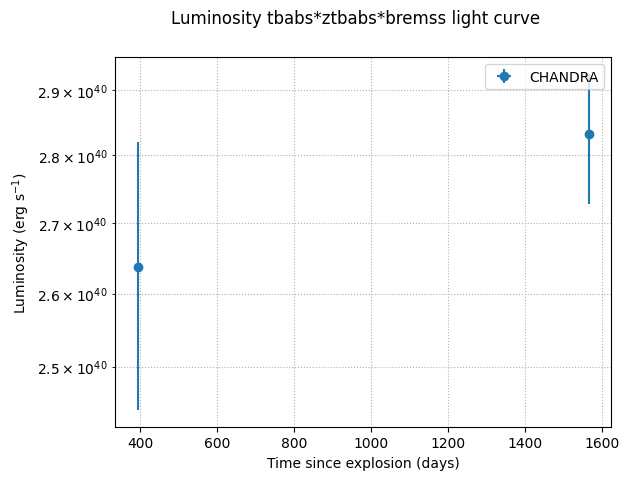

In [8]:
fig_lumin = manager.plot_lumin()

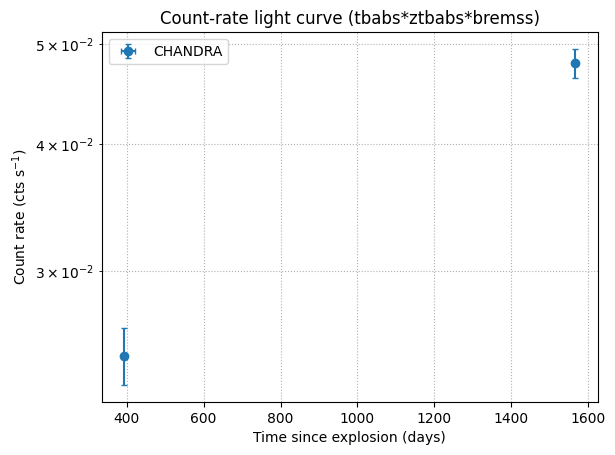

In [9]:
fig_counts = manager.plot_counts()

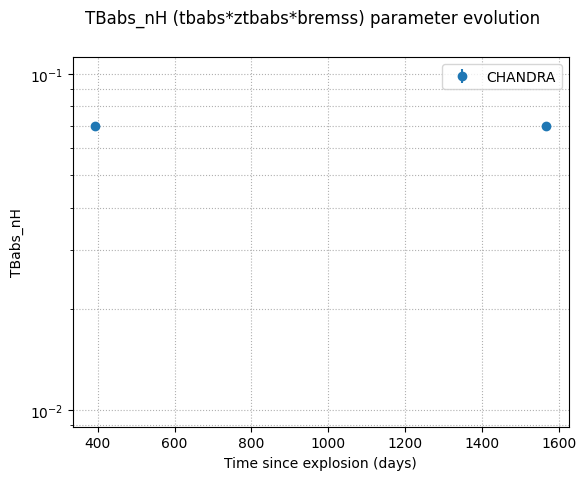

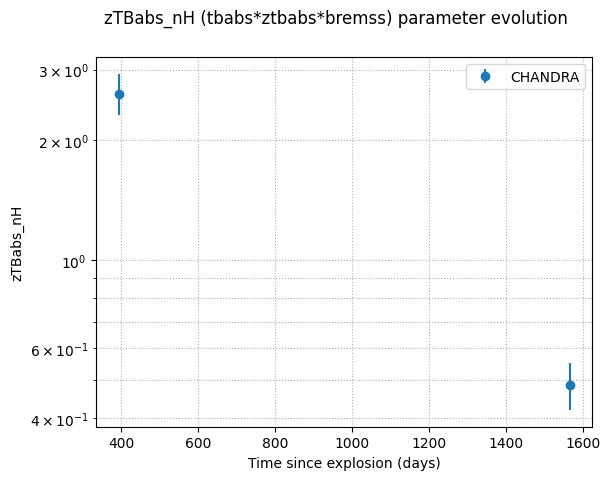

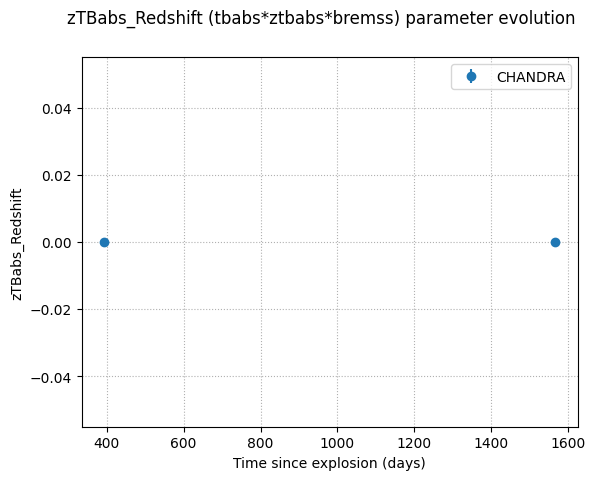

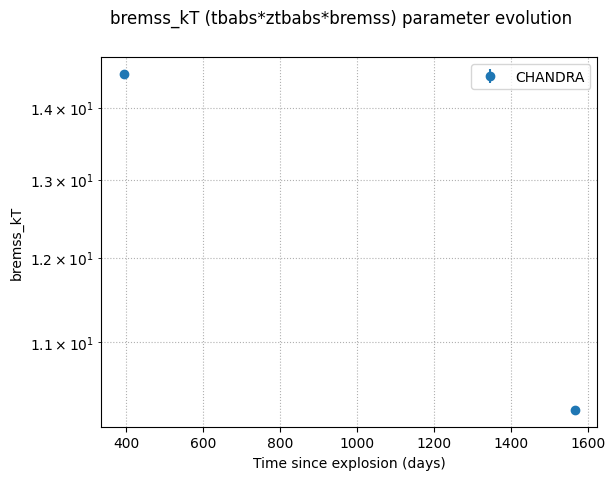

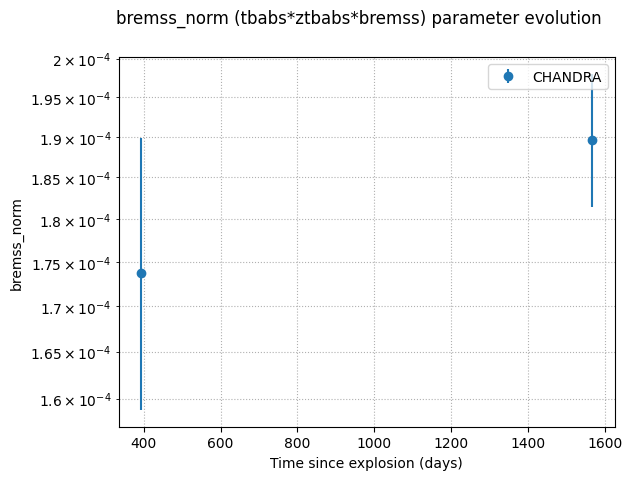

In [10]:
fig_params = manager.plot_params()